# Recursive feature elimination

- [Feature Selection in Machine Learning Book](https://www.trainindata.com/p/feature-selection-in-machine-learning-book)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from feature_engine.selection import RecursiveFeatureElimination

In [2]:
# load the California House price data

X, y = fetch_california_housing(return_X_y=True, as_frame=True)

# Separate data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [3]:
# the ML model for which we want to select features

model = GradientBoostingRegressor(
    n_estimators=5,
    random_state=10,
)

## Feature-engine

In [4]:
sel = RecursiveFeatureElimination(
    estimator = model, # the ML model
    scoring = 'r2', 
    threshold = 0.001, 
    cv=2,
)

sel.fit(X_train, y_train)

RecursiveFeatureElimination(cv=2,
                            estimator=GradientBoostingRegressor(n_estimators=5,
                                                                random_state=10),
                            scoring='r2', threshold=0.001)

In [5]:
# Performance of model trained using all features

sel.initial_model_performance_

np.float64(0.3639885983830904)

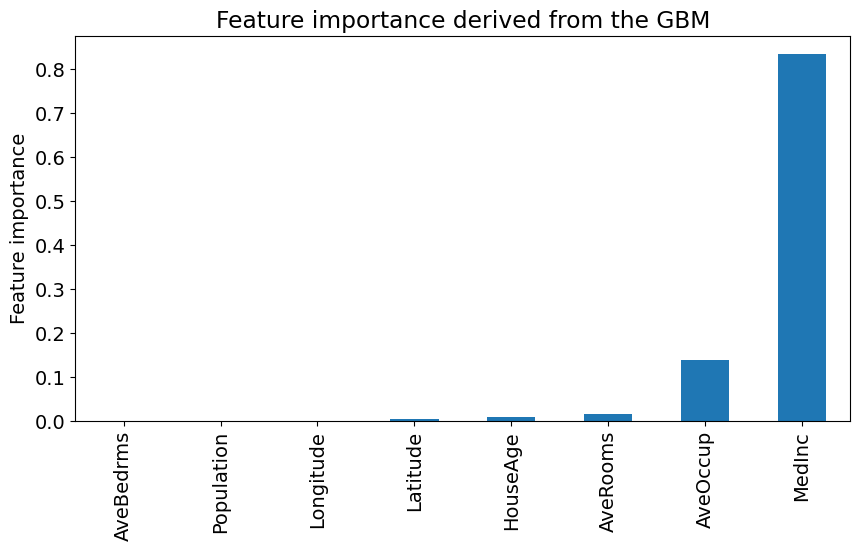

In [6]:
# Feature importance derived from initial model
plt.figure()
plt.rcParams.update({'font.size': 14})

sel.feature_importances_.plot.bar(figsize=(10, 5))
plt.ylabel('Feature importance')
plt.title('Feature importance derived from the GBM')
plt.show()

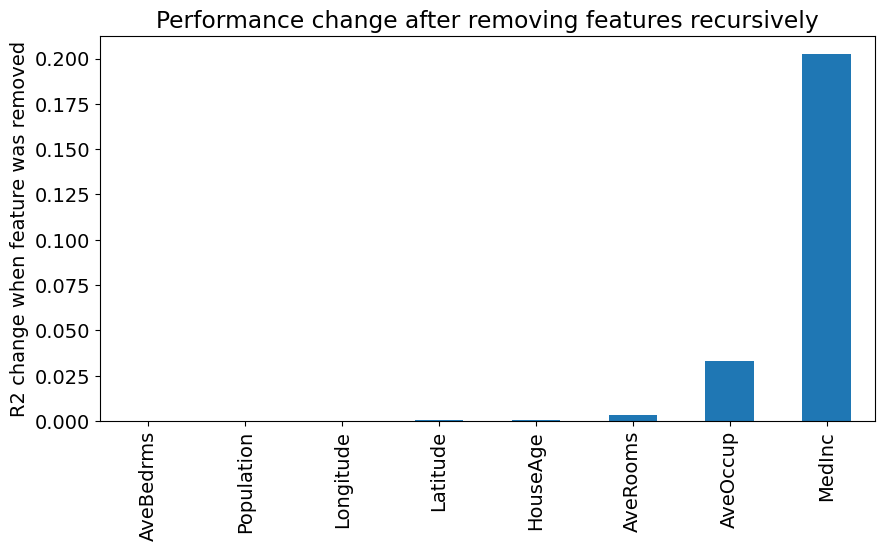

In [7]:
# Changes in performance after removing each feature

pd.Series(sel.performance_drifts_).plot.bar(figsize=(10, 5))
plt.title('Performance change after removing features recursively')
plt.ylabel('R2 change when feature was removed')
plt.show()

In [8]:
# the features to remove

sel.features_to_drop_

['HouseAge', 'AveBedrms', 'Population', 'Latitude', 'Longitude']

In [9]:
# reduce dataset

X_train_t = sel.transform(X_train)
X_test_t = sel.transform(X_test)

X_test_t.head()

,MedInc,AveRooms,AveOccup
14740,4.1518,5.663073,4.180593
10101,5.7796,6.107226,3.020979
20566,4.3487,5.930712,2.910112
2670,2.4511,4.992958,2.746479
15709,5.0049,4.319261,1.712401


## Manual

In [10]:
model.fit(X_train, y_train)

# calculate r2 in the test set
y_pred_test = model.predict(X_test)
r2_full = r2_score(y_test, y_pred_test)

print(f'R2 all features = {r2_full}')

R2 all features = 0.3564875693230235


In [11]:
# rank features by importance
features = pd.Series(model.feature_importances_,
                     index=X_train.columns).sort_values(ascending=True)

features.head()

AveBedrms     0.000000
Longitude     0.000000
Latitude      0.000000
Population    0.000000
HouseAge      0.009201
dtype: float64

In [12]:
# make list with ordered features
features = list(features.index)

In [13]:
tol = 0.001

# the features we should remove
features_to_remove = []

# we loop over all the features, in order of importance:
for feature in features:

    # initialise model
    model_int = clone(model)

    # fit model with all variables minus the removed features
    # and the feature to be evaluated
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction using the test set
    y_pred_test = model_int.predict(
        X_test.drop(features_to_remove + [feature], axis=1))

    # calculate the new r2
    r2_int = r2_score(y_test, y_pred_test)

    # determine the drop in the r2
    diff_r2 = r2_full - r2_int

    # assess the r2
    if diff_r2 < tol:
        # if the drop in the r2 is small and we remove the
        # feature, we need to set the new r2 to the one based on
        # the remaining features
        r2_full = r2_int

        # and append the feature to remove to the collecting list
        features_to_remove.append(feature)

print(f'Number of features to remove: {len(features_to_remove)}')

Number of features to remove: 4


In [14]:
# the features to keep

features_to_keep = [x for x in features if x not in features_to_remove]

In [15]:
# finally let's assess the performance of a model
# trained on the selected features

model_final = clone(model)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict(X_test[features_to_keep])

# calculate roc-auc
r2_final = r2_score(y_test, y_pred_test)
print(f'r2 selected features= {r2_final}')

r2 selected features= 0.3564875693230233
